In [22]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# Groundwater Level (WTE) Data Quality Check

In [33]:
import os
import pandas as pd

file_path = '../data/raw/groundwater/GSLB_1900-2023_TS_with_aquifers.csv'

if os.path.exists(file_path):
    wte_data = pd.read_csv(file_path)
    wte_data['Date'] = pd.to_datetime(wte_data['Date'])
    print("File loaded successfully!")
else:
    print(f"File not found: {file_path}. Please make sure the file exists at the specified path.")

File loaded successfully!


Wells with single measurement: 4837 (56.2%)
Wells with two measurements: 827 (9.6%)

Detailed Quality Report:
--------------------------------------------------
Total number of wells: 8602
Wells with single measurement: 4837
Wells with two measurements: 827
Average measurements per well: 20.60
Median measurements per well: 1.00
Average time span per well: 3133.24 days
Average measurements per year: 1.97


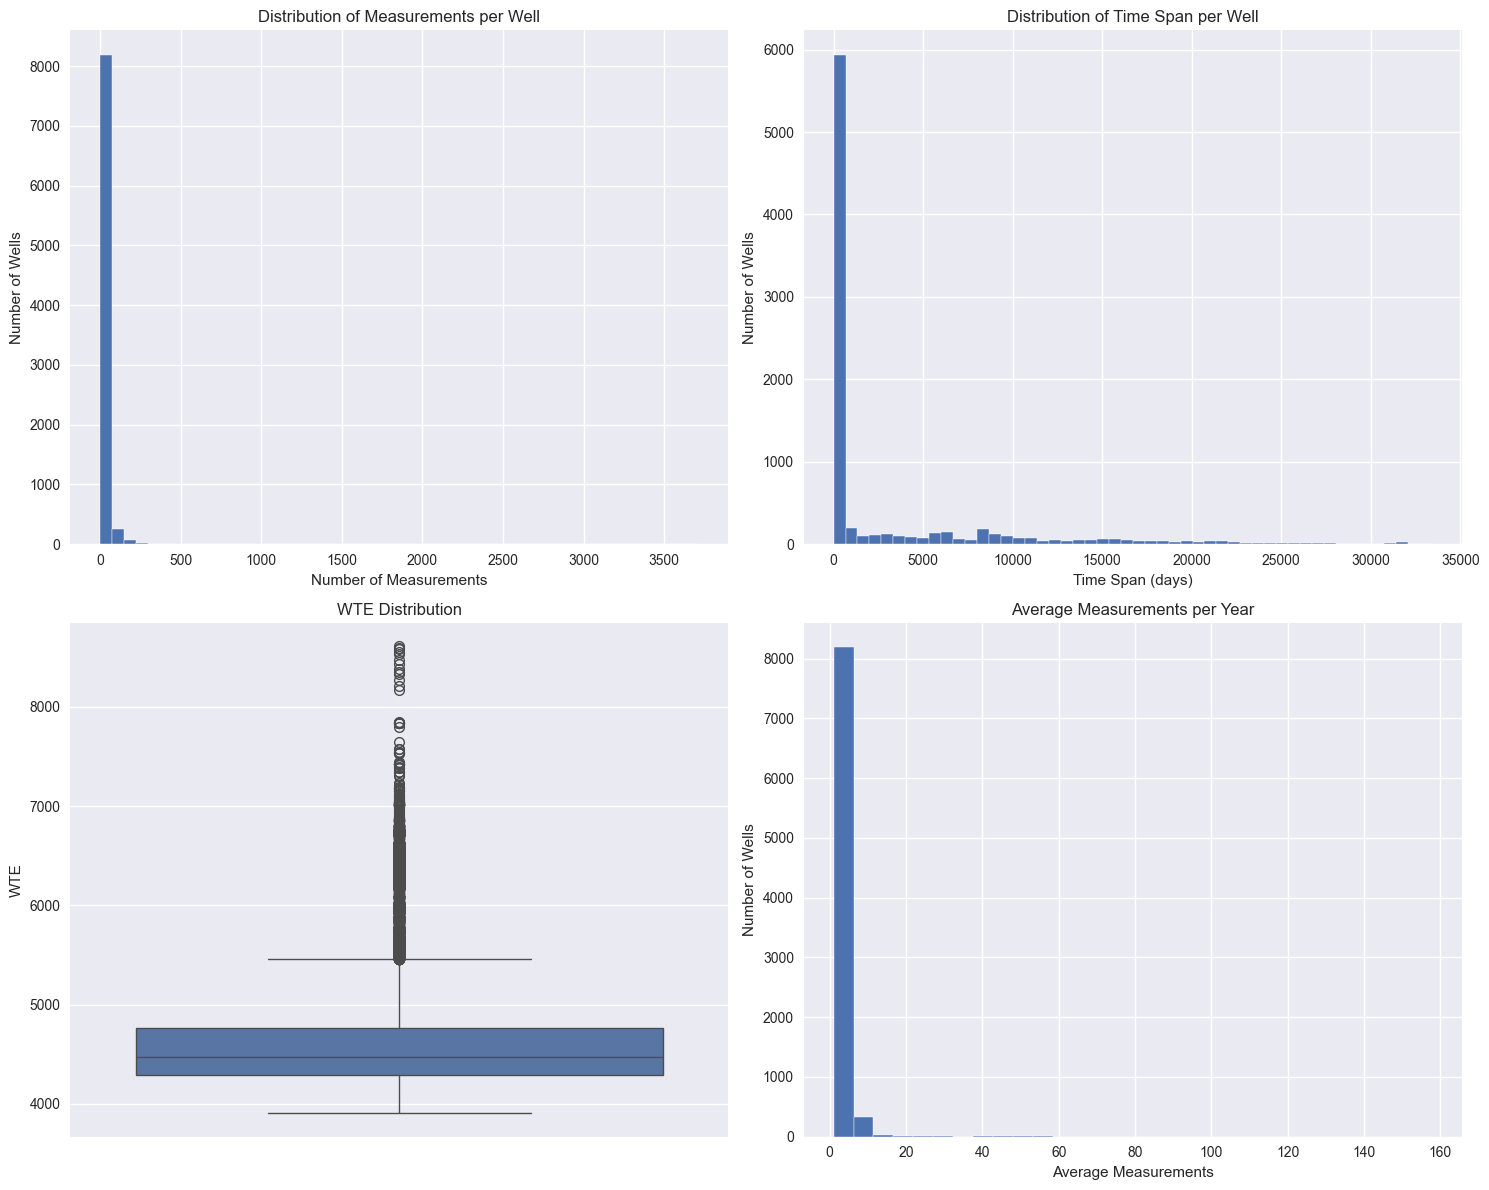

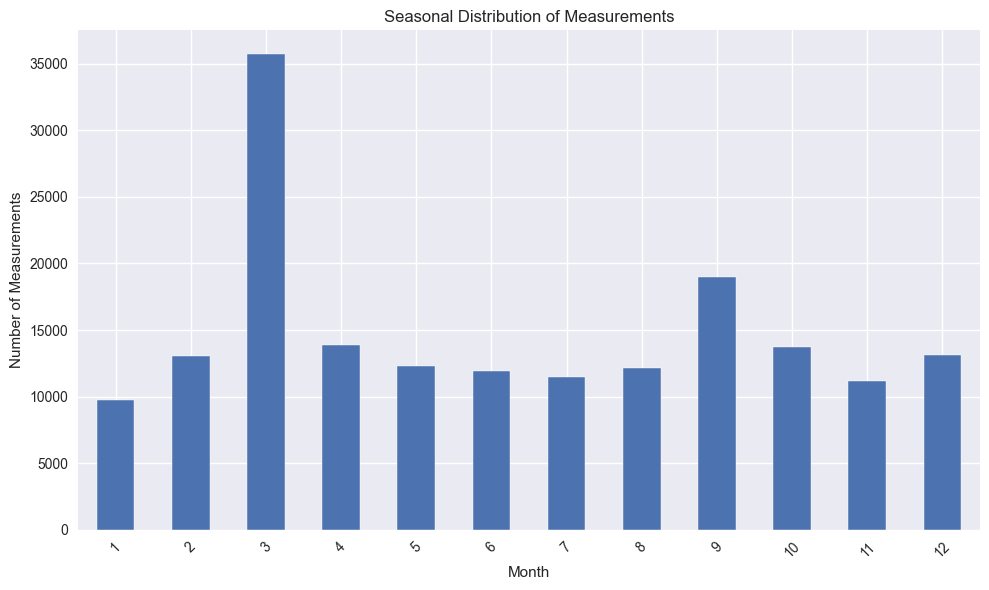

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def analyze_wte_data_quality(df):
    """
    Analyze the quality of water table elevation (WTE) data
    Parameters:
        df: DataFrame containing WTE measurements with columns 'Well_ID', 'Date', 'WTE'
    Returns:
        report: Dictionary containing quality metrics
    """
    # 1. Analysis of measurement counts per well
    measurement_counts = df.groupby('Well_ID').size()

    # Count wells with limited measurements
    single_point_wells = measurement_counts[measurement_counts == 1]
    two_point_wells = measurement_counts[measurement_counts == 2]

    print(f"Wells with single measurement: {len(single_point_wells)} ({len(single_point_wells)/len(measurement_counts):.1%})")
    print(f"Wells with two measurements: {len(two_point_wells)} ({len(two_point_wells)/len(measurement_counts):.1%})")

    # 2. Time span analysis
    time_analysis = df.groupby('Well_ID').agg({
        'Date': lambda x: (x.max() - x.min()).days if len(x) > 1 else 0
    }).rename(columns={'Date': 'time_span_days'})

    # 3. Measurement frequency analysis
    df['Year'] = df['Date'].dt.year
    measurements_per_year = df.groupby(['Well_ID', 'Year']).size().reset_index(name='measurements')
    avg_measurements_per_year = measurements_per_year.groupby('Well_ID')['measurements'].mean()

    # 4. Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 4.1 Distribution of measurements per well
    measurement_counts.hist(bins=50, ax=ax1)
    ax1.set_title('Distribution of Measurements per Well')
    ax1.set_xlabel('Number of Measurements')
    ax1.set_ylabel('Number of Wells')

    # 4.2 Distribution of time spans
    time_analysis['time_span_days'].hist(bins=50, ax=ax2)
    ax2.set_title('Distribution of Time Span per Well')
    ax2.set_xlabel('Time Span (days)')
    ax2.set_ylabel('Number of Wells')

    # 4.3 WTE distribution
    sns.boxplot(y='WTE', data=df, ax=ax3)
    ax3.set_title('WTE Distribution')

    # 4.4 Average measurements per year
    avg_measurements_per_year.hist(bins=30, ax=ax4)
    ax4.set_title('Average Measurements per Year')
    ax4.set_xlabel('Average Measurements')
    ax4.set_ylabel('Number of Wells')

    plt.tight_layout()

    # 5. Generate quality report
    report = {
        'total_wells': len(measurement_counts),
        'single_point_wells': len(single_point_wells),
        'two_point_wells': len(two_point_wells),
        'avg_measurements_per_well': measurement_counts.mean(),
        'median_measurements_per_well': measurement_counts.median(),
        'avg_time_span_days': time_analysis['time_span_days'].mean(),
        'avg_measurements_per_year': avg_measurements_per_year.mean()
    }

    # Print detailed report
    print("\nDetailed Quality Report:")
    print("-" * 50)
    print(f"Total number of wells: {report['total_wells']}")
    print(f"Wells with single measurement: {report['single_point_wells']}")
    print(f"Wells with two measurements: {report['two_point_wells']}")
    print(f"Average measurements per well: {report['avg_measurements_per_well']:.2f}")
    print(f"Median measurements per well: {report['median_measurements_per_well']:.2f}")
    print(f"Average time span per well: {report['avg_time_span_days']:.2f} days")
    print(f"Average measurements per year: {report['avg_measurements_per_year']:.2f}")

    return report

def analyze_seasonal_distribution(df):
    """
    Analyze the seasonal distribution of measurements
    Parameters:
        df: DataFrame containing measurements with 'Date' column
    Returns:
        seasonal_dist: Series containing count of measurements per month
    """
    df['Month'] = df['Date'].dt.month
    seasonal_dist = df.groupby('Month').size()

    plt.figure(figsize=(10, 6))
    seasonal_dist.plot(kind='bar')
    plt.title('Seasonal Distribution of Measurements')
    plt.xlabel('Month')
    plt.ylabel('Number of Measurements')
    plt.xticks(rotation=45)
    plt.tight_layout()

    return seasonal_dist

# Run the analysis
report = analyze_wte_data_quality(wte_data)
seasonal_distribution = analyze_seasonal_distribution(wte_data)

# Hydrography data

In [39]:
# Hydrography Data Analysis
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load hydrography data
hydrography_path = '../data/raw/hydrography/'

# Load shapefiles
gsl_basin = gpd.read_file(hydrography_path + 'gsl_basin.shp')
gsl_catchment = gpd.read_file(hydrography_path + 'gsl_catchment.shp')
gslb_stream = gpd.read_file(hydrography_path + 'gslb_stream.shp')
lake = gpd.read_file(hydrography_path + 'lake.shp')
well_shp = gpd.read_file(hydrography_path + 'well_shp.shp')

# Load CSV data
gsl_nwm_gage = pd.read_csv(hydrography_path + 'gsl_nwm_gage.csv')

print("Hydrography data loaded successfully!")
print(f"Basin features: {len(gsl_basin)}")
print(f"Catchment features: {len(gsl_catchment)}")
print(f"Stream features: {len(gslb_stream)}")
print(f"Lake features: {len(lake)}")
print(f"Well features: {len(well_shp)}")
print(f"Gage data points: {len(gsl_nwm_gage)}")

Hydrography data loaded successfully!
Basin features: 1
Catchment features: 7013
Stream features: 6717
Lake features: 202
Well features: 8752
Gage data points: 78


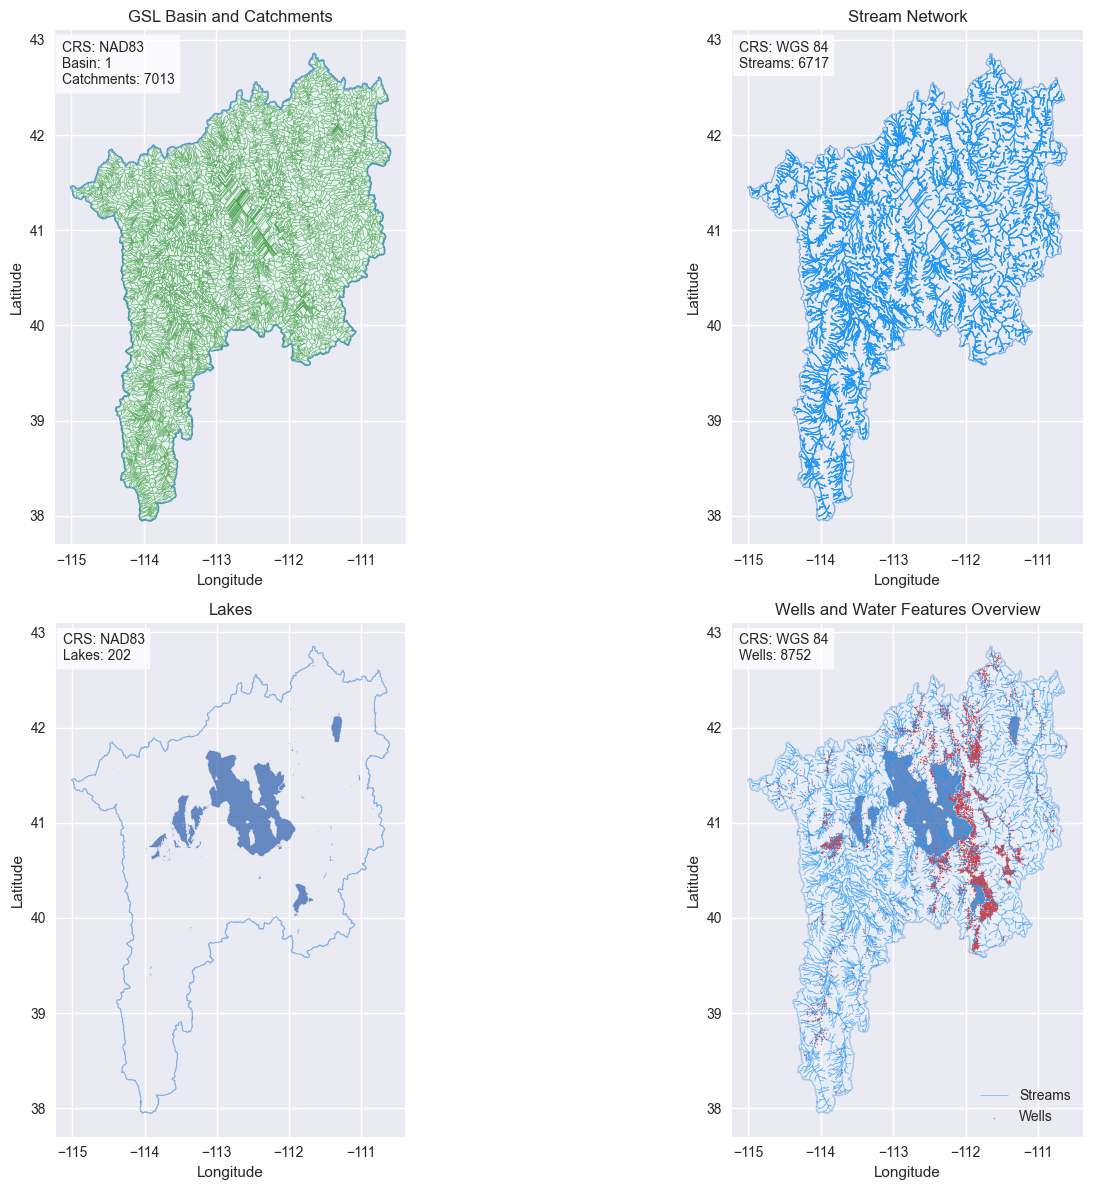

In [42]:
# Create comprehensive hydrography plots with improved colors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Basin and catchment overview
ax1 = axes[0, 0]
gsl_basin.plot(ax=ax1, color='#E3F2FD', alpha=0.7, edgecolor='#1976D2', linewidth=1.5)
gsl_catchment.plot(ax=ax1, color='#E8F5E9', alpha=0.5, edgecolor='#43A047')
ax1.set_title('GSL Basin and Catchments')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# Add legend
ax1.text(0.02, 0.98, f'CRS: {gsl_basin.crs.name}\nBasin: 1\nCatchments: {len(gsl_catchment)}',
         transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

# Plot 2: Streams
ax2 = axes[0, 1]
gsl_basin.plot(ax=ax2, color='none', edgecolor='#1976D2', linewidth=0.8, alpha=0.5)
gslb_stream.plot(ax=ax2, color='#2196F3', linewidth=0.8)
ax2.set_title('Stream Network')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.text(0.02, 0.98, f'CRS: {gslb_stream.crs.name}\nStreams: {len(gslb_stream)}',
         transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

# Plot 3: Lakes
ax3 = axes[1, 0]
gsl_basin.plot(ax=ax3, color='none', edgecolor='#1976D2', linewidth=0.8, alpha=0.5)
lake.plot(ax=ax3, color='#0D47A1', alpha=0.6)
ax3.set_title('Lakes')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.text(0.02, 0.98, f'CRS: {lake.crs.name}\nLakes: {len(lake)}',
         transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

# Plot 4: Well locations with water features
ax4 = axes[1, 1]
gsl_basin.plot(ax=ax4, color='#E3F2FD', alpha=0.3, edgecolor='#1976D2', linewidth=1)
gslb_stream.plot(ax=ax4, color='#2196F3', linewidth=0.5, alpha=0.6, label='Streams')
lake.plot(ax=ax4, color='#0D47A1', alpha=0.6, label='Lakes')
well_shp.plot(ax=ax4, color='#E53935', markersize=0.5, alpha=0.6, label='Wells')
ax4.set_title('Wells and Water Features Overview')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.text(0.02, 0.98, f'CRS: {well_shp.crs.name}\nWells: {len(well_shp)}',
         transform=ax4.transAxes, bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')
ax4.legend(loc='lower right')

plt.tight_layout()
plt.show()

# streamflow

Gage Data Summary:
         id                                               name  \
0  10011200  WEST FORK BEAR RIVER AT WHITNEY DAM - NR OAKLE...   
1  10011500            BEAR RIVER NEAR UTAH-WYOMING STATE LINE   
2  10015700  SULPHUR CR.AB.RES.BL.LA CHAPELLE CR.NR EVANSTO...   
3  10015900       SULPHUR CREEK BL RES. - NEAR EVANSTON - WYO.   
4  10016900                        BEAR RIVER AT EVANSTON - WY   

                  River   latitude   longitude  elevation_m    state  
0  WEST FORK BEAR RIVER  40.841614 -110.927119         2797     Utah  
1            BEAR RIVER  40.965225 -110.853508         2432     Utah  
2         SULPHUR CREEK  41.129114 -110.806563         2205  Wyoming  
3         SULPHUR CREEK  41.156058 -110.835176         2173  Wyoming  
4            BEAR RIVER  41.270224 -110.963793         2057  Wyoming  

Number of gages: 78
States represented: ['Utah' 'Wyoming' 'Idaho']
Elevation range: 1286 - 2797 m


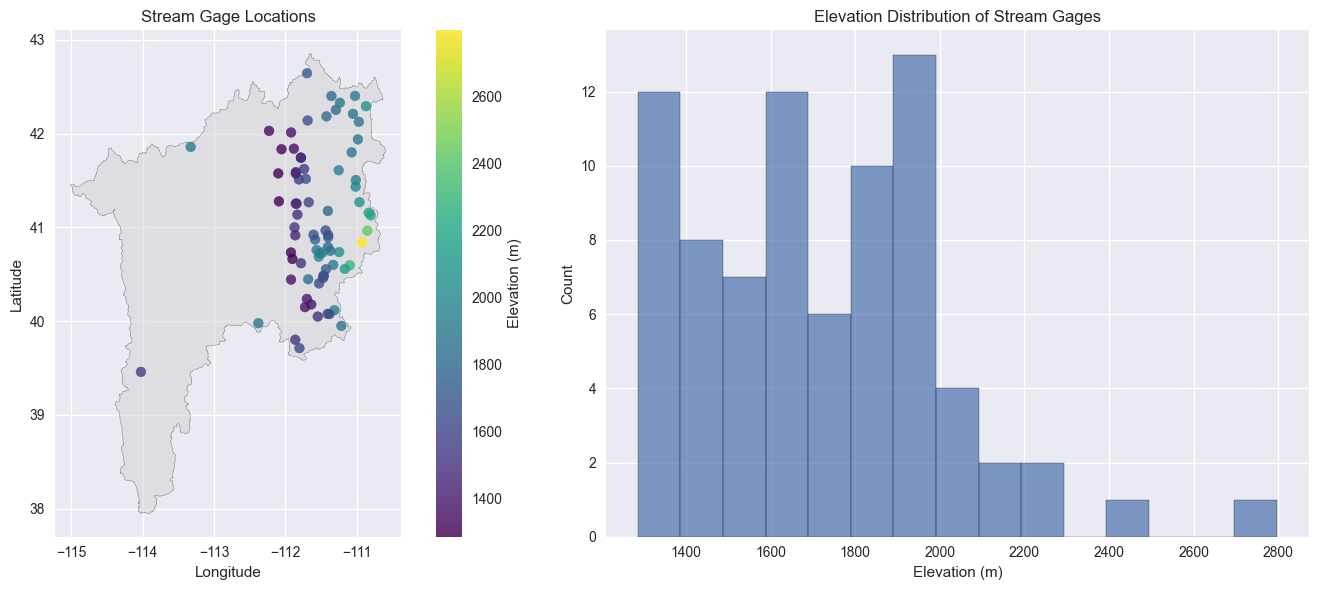

In [41]:
# Analyze gage data
print("Gage Data Summary:")
print(gsl_nwm_gage.head())
print(f"\nNumber of gages: {len(gsl_nwm_gage)}")
print(f"States represented: {gsl_nwm_gage['state'].unique()}")
print(f"Elevation range: {gsl_nwm_gage['elevation_m'].min():.0f} - {gsl_nwm_gage['elevation_m'].max():.0f} m")

# Plot gage locations with elevation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gage locations
gsl_basin.plot(ax=ax1, color='lightgray', alpha=0.5, edgecolor='black')
scatter = ax1.scatter(gsl_nwm_gage['longitude'], gsl_nwm_gage['latitude'], 
                     c=gsl_nwm_gage['elevation_m'], cmap='viridis', s=50, alpha=0.8)
ax1.set_title('Stream Gage Locations')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(scatter, ax=ax1, label='Elevation (m)')

# Elevation distribution
ax2.hist(gsl_nwm_gage['elevation_m'], bins=15, alpha=0.7, edgecolor='black')
ax2.set_title('Elevation Distribution of Stream Gages')
ax2.set_xlabel('Elevation (m)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

## gage classification

In [46]:
# Load GAGES-II reference and non-reference classification data
gage_class = pd.read_excel('../data/raw/streamflow/GAGES-II_ref_non_ref.xlsx')

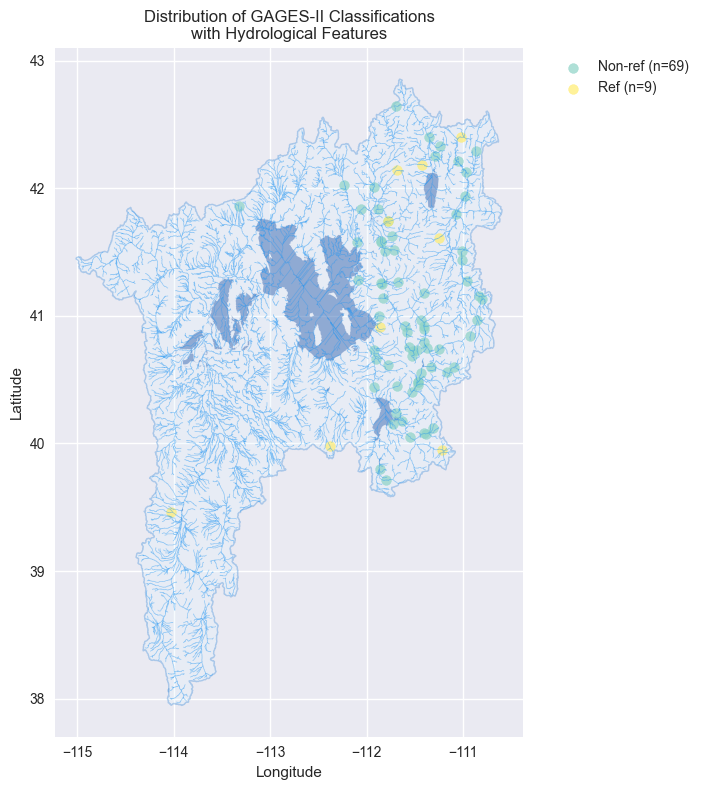

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot basin boundary
gsl_basin.plot(ax=ax1, color='#E3F2FD', alpha=0.3, edgecolor='#1976D2', linewidth=1)

# Plot streams and lakes
gslb_stream.plot(ax=ax1, color='#2196F3', linewidth=0.5, alpha=0.4)
lake.plot(ax=ax1, color='#0D47A1', alpha=0.4)

# Create a color map that will automatically handle any number of classes
unique_classes = gage_with_class['CLASS'].fillna('Unclassified').unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_classes)))
color_dict = dict(zip(unique_classes, colors))

# Plot each class and count stations
for class_type in unique_classes:
    mask = gage_with_class['CLASS'].fillna('Unclassified') == class_type
    subset = gage_with_class[mask]
    count = len(subset)
    ax1.scatter(subset['longitude'], subset['latitude'],
               c=[color_dict[class_type]],
               label=f'{class_type} (n={count})',
               s=50, alpha=0.7)

ax1.set_title('Distribution of GAGES-II Classifications\nwith Hydrological Features')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()